# Import the modules

In [273]:
import tarfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pickle
import networkx as nx
#from wordcloud import WordCloud
%matplotlib inline

# Import the data

In [24]:
# File and folder names
DATA_FOLDER = 'Data/'
CHARACTER_DATASET = DATA_FOLDER + 'characters.pkl'
MOVIE_DATASET = DATA_FOLDER + 'movies.pkl'

SUMMARIES_DATASET = DATA_FOLDER + 'plot_summaries.txt'
NLP_DATASET = DATA_FOLDER + 'corenlp_plot_summaries.tar'

MALE_SENTENCES = DATA_FOLDER + "male_sentences.pkl"
FEMALE_SENTENCES = DATA_FOLDER + "female_sentences.pkl"

MALE_SENTIMENTS = DATA_FOLDER + "male_sentiments.pkl"
FEMALE_SENTIMENTS = DATA_FOLDER + "female_sentiments.pkl"

In [25]:
# Function to load data
def load_metadata(path, column_names, header=None, low_memory=False):
    return pd.read_table(path, header=header, names=column_names)

In [178]:
# Load data
characters = pd.read_pickle(CHARACTER_DATASET)
movies = pd.read_pickle(MOVIE_DATASET)

# Little cleaning

As we pickled our data, we just have to turn the dates back to the pandas datetime format.

We also keep a version of our datasets without dropping the NaN (which are quite numerous, see below).

## Dates as datetime

Change the format of dates

In [179]:
movies.Movie_release_date = pd.to_datetime(movies.Movie_release_date,format='%Y').dt.year
characters.Movie_release_date = pd.to_datetime(characters.Movie_release_date,format='%Y').dt.year
characters.Actor_date_of_birth = pd.to_datetime(characters.Actor_date_of_birth,format='%Y',utc=True,errors='coerce').dt.year

## Rows with NaN

We detect the number of rows with NaN values for movies and characters datasets

In [180]:
print('Number of NaN in the movies dataset:\n',movies.isnull().sum())
print('>>> {perc:.2f}% of the rows with at least one NanN'.format(perc=movies.isnull().sum().max()/len(movies)*100))
print('\nNumber of NaN in the characters dataset:\n',characters.isnull().sum())
print('>>> {perc:.2f}% of the rows with at least one NanN'.format(perc=characters.isnull().sum().max()/len(characters)*100))

Number of NaN in the movies dataset:
 Wikipedia_movie_ID              0
Freebase_movie_ID               0
Movie_name                      0
Movie_release_date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64
>>> 89.72% of the rows with at least one NanN

Number of NaN in the characters dataset:
 Wikipedia_movie_ID                      0
Freebase_movie_ID                       0
Movie_release_date                   9994
Character_name                     257856
Actor_date_of_birth                106145
Actor_gender                        45603
Actor_height_meters                295825
Actor_ethnicity_Freebase_ID        344589
Actor_name                           1228
Actor_age_at_movie_release         158102
Freebase_character_actor_map_ID         0
Freebase_character_ID              257846
Freebase_actor_ID                     815
dtype: i

In [181]:
# We separate the datasets in two parts: one with droped rows with NaN and one that we do not touch
characters_nodrop = characters.copy()
movies_nodrop = movies.copy()

characters = characters.dropna()
movies = movies.dropna()

# Visualisations

## Movies

### General statistics

In [182]:
movies_nodrop.describe()

,Wikipedia_movie_ID,Movie_release_date,Movie_box_office_revenue,Movie_runtime
count,8.174100e+04,74839.000000,8.401000e+03,6.129100e+04
mean,1.740784e+07,1977.489892,4.799363e+07,1.118192e+02
std,1.098791e+07,28.886090,1.121753e+08,4.360070e+03
min,3.300000e+02,1888.000000,1.000000e+04,0.000000e+00
25%,7.323695e+06,1956.000000,2.083193e+06,8.100000e+01
50%,1.777899e+07,1985.000000,1.063969e+07,9.300000e+01
75%,2.715573e+07,2004.000000,4.071696e+07,1.060000e+02
max,3.750192e+07,2016.000000,2.782275e+09,1.079281e+06


As expected, the standard variation for the box office revenue is very high. We therefore decide to use the median revenue instead of mean revenue, and plot in y log-scale.

### Some evolutions

#### About the revenue

In [183]:
# General parameters for the plots

step = 3 # step for the dates in the x-axis ticks
xmin = int(min(movies.Movie_release_date))
xmax = int(max(movies.Movie_release_date))

Evolution of box office revenue

Text(0.5, 1.0, 'Evolution of median box office revenue per year (log-linear)')

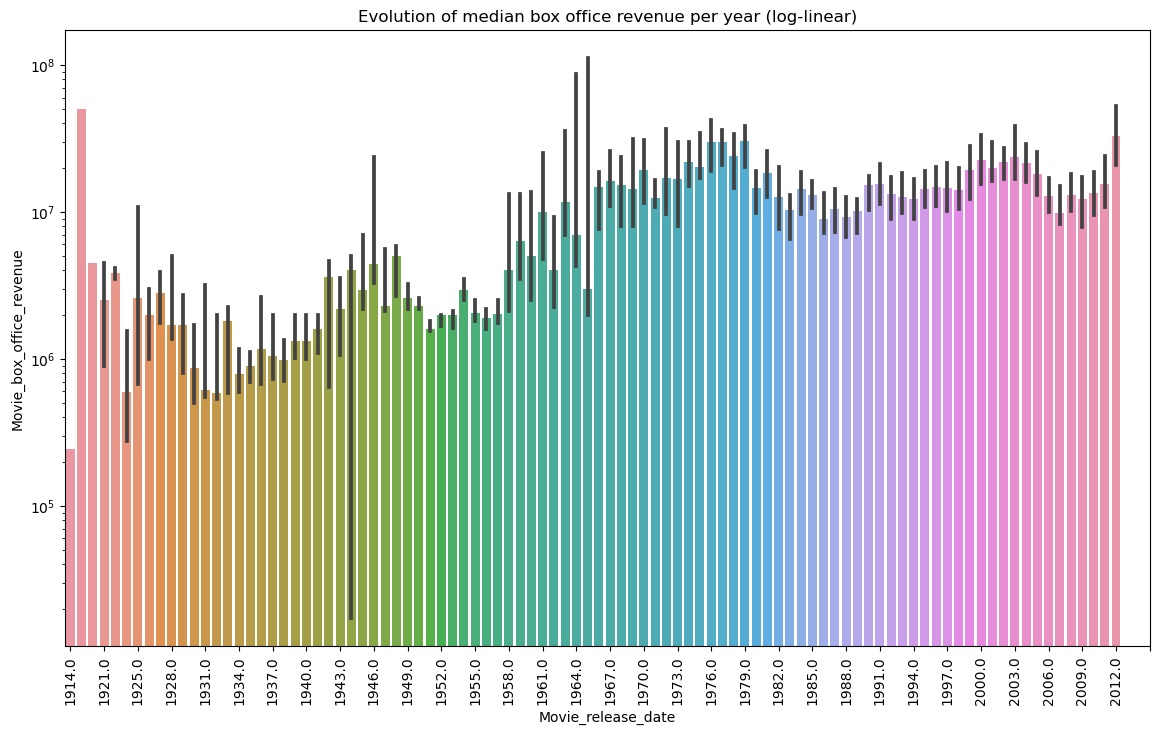

In [184]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = movies, x='Movie_release_date', y='Movie_box_office_revenue',estimator='median', ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
plt.yscale('log')
plt.title('Evolution of median box office revenue per year (log-linear)')

The high peaks in 1915 seem strange, as for the relative high revenue around 1921. Let us plot the evolution of the number of films per year (only those with a valid revenue i.e non-NaN).

Text(0.5, 1.0, 'Evolution of number of films per year (log-linear)')

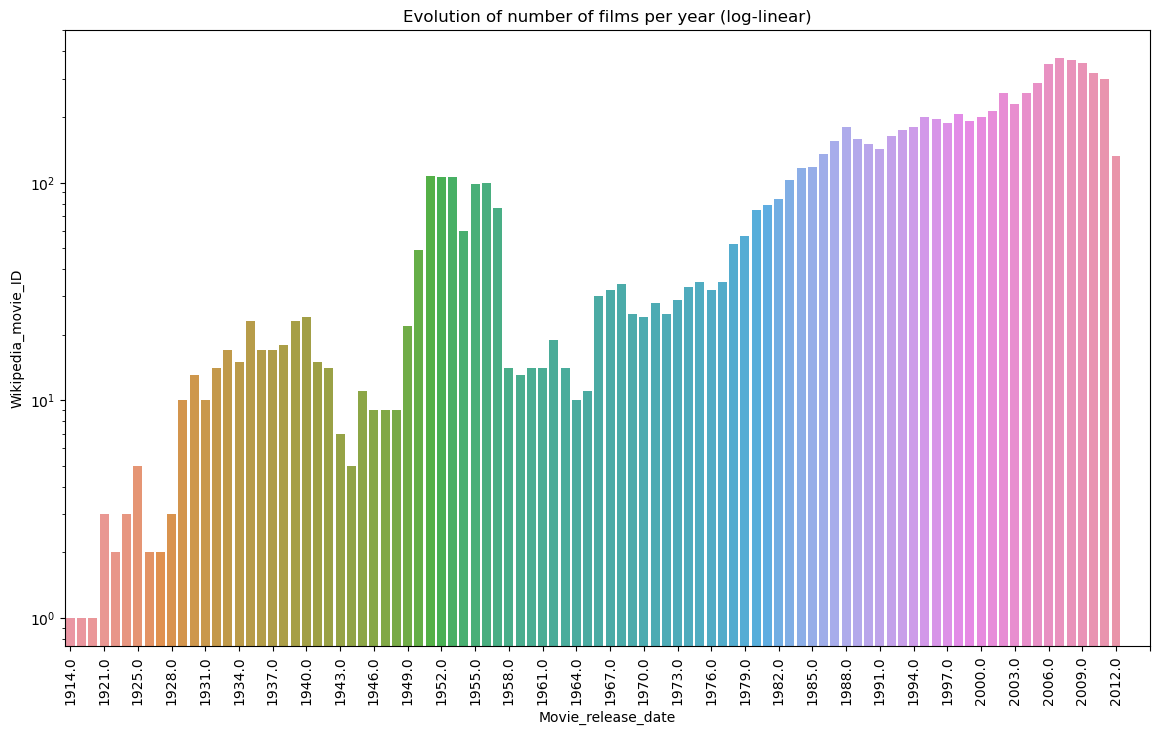

In [185]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = movies, x='Movie_release_date', y='Wikipedia_movie_ID',estimator=len, ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
#plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Evolution of number of films per year (log-linear)')

Indeed, there was only one film in 1915, and not a lot around 1921. Only the "best films" of the epoch must have been registered in the dataset.

Now let us see the evolution of the median revenue per film.

Text(0.5, 1.0, 'Evolution of median revenue per film (log-linear)')

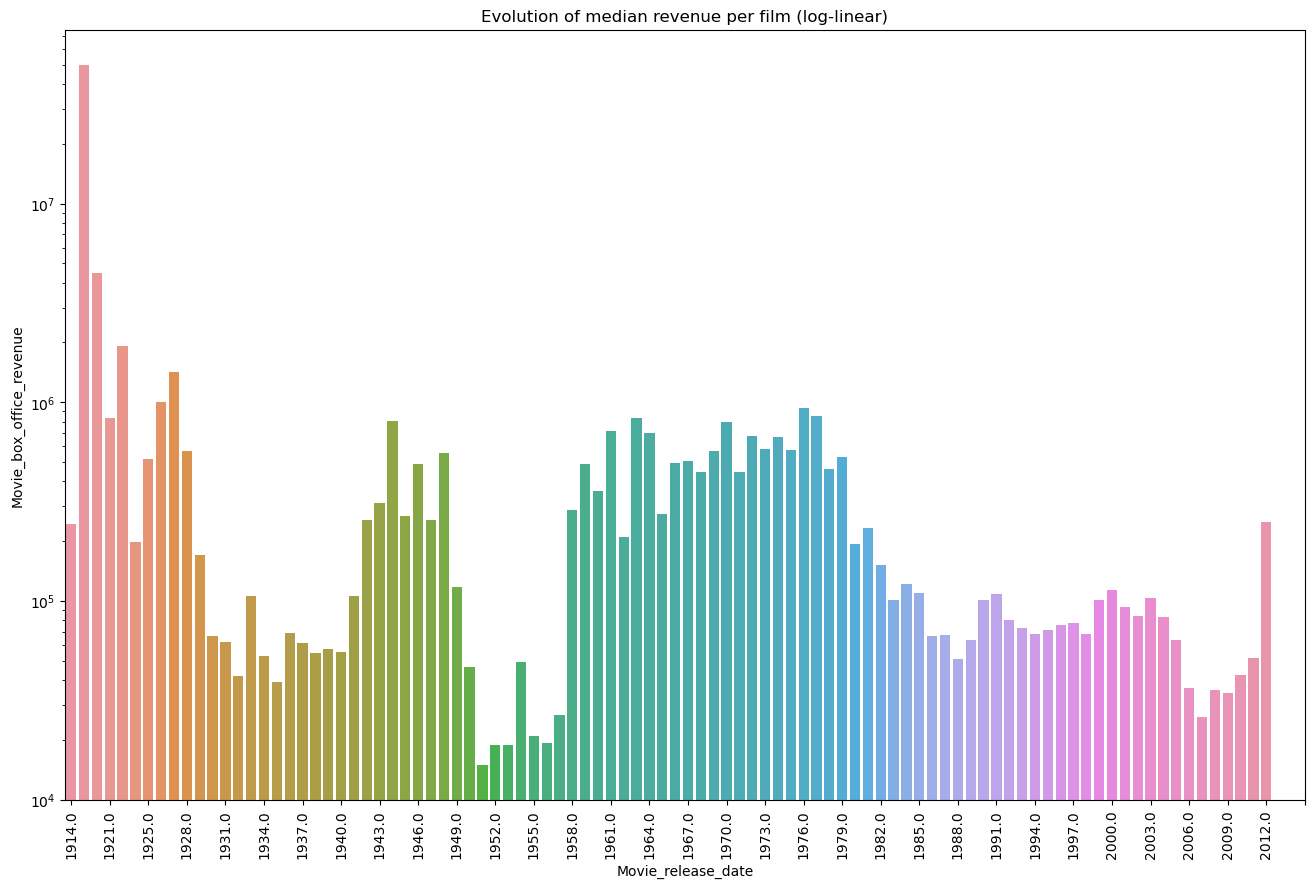

In [186]:
movies_by_year = movies.groupby('Movie_release_date')
movies_by_year_count = movies_by_year.agg('count')
movies_by_year_median = movies_by_year.agg('median',numeric_only=True)
fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(x=movies_by_year_median.index, y=movies_by_year_median.Movie_box_office_revenue/movies_by_year_count.Movie_box_office_revenue, ax=ax)
plt.xticks([i for i in range(0,xmax+1-xmin,3)],rotation=90)
plt.yscale('log')
plt.title('Evolution of median revenue per film (log-linear)')

If we do not take in to account the first few years with very little number of films, iIt appears (not conclusive yet, but just an intuition with the plot) that the median revenue per film is "relatively constant" compared to the median revenue. There was a drop around the 50's (missing data or real effect ?), and a little decrease since 1980.

### What about the genres ?

How many movies do we have per genre ?

In [187]:
genres ={}
for i in movies.Movie_genres:
    for j in i:
        if j not in genres:
            genres[j] = 1
        else:
            genres[j]+=1
sorted_genres = sorted(genres.items(), key=lambda x:x[1],reverse=True)
sorted_genres

[('Drama', 4265),
 ('Comedy', 3166),
 ('Romance Film', 2026),
 ('Thriller', 1945),
 ('Action', 1744),
 ('Action/Adventure', 1359),
 ('Crime Fiction', 1274),
 ('Adventure', 1155),
 ('Indie', 1046),
 ('Romantic comedy', 892),
 ('Family Film', 838),
 ('Romantic drama', 769),
 ('Horror', 764),
 ('Fantasy', 699),
 ('Mystery', 677),
 ('Period piece', 668),
 ('Science Fiction', 643),
 ('Film adaptation', 607),
 ('Crime Thriller', 575),
 ('World cinema', 574),
 ('Comedy-drama', 550),
 ('Musical', 539),
 ('War film', 410),
 ('Teen', 400),
 ('Psychological thriller', 398),
 ('Black-and-white', 361),
 ('Coming of age', 351),
 ('Black comedy', 350),
 ('Animation', 327),
 ('Parody', 320),
 ('Cult', 315),
 ('Sports', 306),
 ("Children's/Family", 290),
 ('Biography', 286),
 ('LGBT', 279),
 ('Family Drama', 271),
 ('Suspense', 271),
 ('Western', 268),
 ('Biographical film', 252),
 ('Buddy film', 220),
 ('Costume drama', 219),
 ('Slapstick', 214),
 ('Satire', 199),
 ('Slasher', 191),
 ('Supernatural', 

In [188]:
main_genres = [elt[0] for elt in sorted_genres[:25]] # Completely arbitrary choice of the number of genres to keep
revenue_per_genre = {}
for genre in main_genres:
    count = 0
    revenues = []
    for index,row in movies.iterrows():
        if genre in row.Movie_genres:
            revenues.append(row.Movie_box_office_revenue)
    revenue_per_genre[genre] = sorted(revenues)[int(len(revenues)/2)]

In [189]:
df_revenue_per_genre = pd.DataFrame.from_dict(revenue_per_genre, orient ='index')
df_revenue_per_genre.rename(columns={0:'Revenue'},inplace=True)
#df_revenue_per_genre.sort_values(by='Revenue',inplace=True,ascending=False)

Text(0.5, 1.0, 'Median revenue per genre (log scale)')

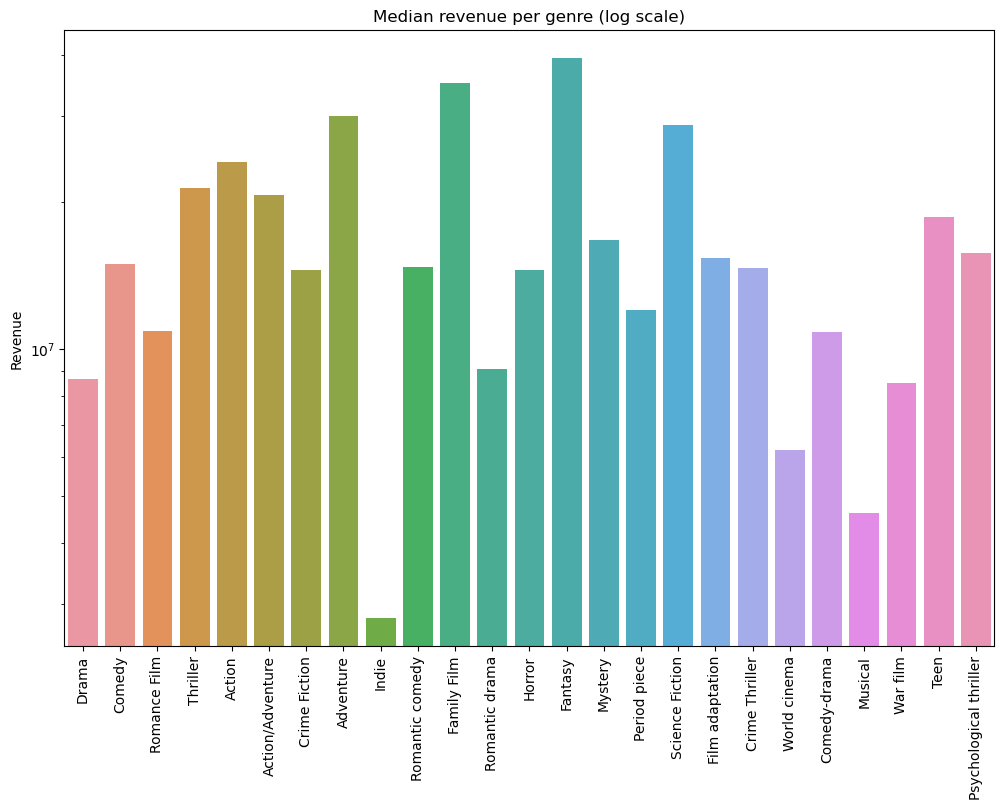

In [190]:
fig,ax = plt.subplots(figsize=(12,8))
sns.barplot(df_revenue_per_genre,x=df_revenue_per_genre.index,y='Revenue')
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Median revenue per genre (log scale)')

We can see that the number of films per genre do not seem to be correlated with the revenue of the film. But to be conclusive we will have to be careful about the number of genres per film (e.g if 'Drama' is always cited as a genre with 4 other genres, then the film might not be a pure Drama), and other counfounders.

Now let us have a look at the characters dataset.

## Characters

In [191]:
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001.0,Commander Helena Braddock,1949.0,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006.0,Taper Guy,1971.0,M,1.87,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999.0,Sandii,1975.0,F,1.68,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


### About the numbers

How many films per actor...

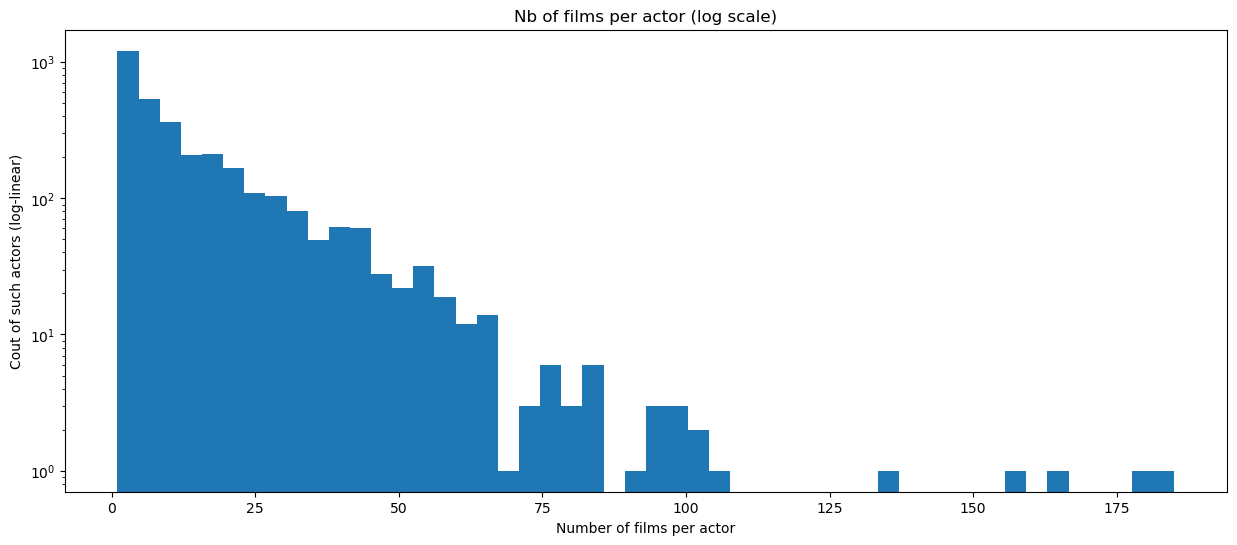

In [192]:
characters_per_actor = characters.groupby('Actor_name')
fig,ax = plt.subplots(figsize=(15,6))
plt.hist(characters_per_actor.agg('count').Wikipedia_movie_ID,bins=50)
ax.set(yscale='log')
plt.title('Nb of films per actor (log scale)')
plt.xlabel('Number of films per actor')
plt.ylabel('Cout of such actors (log-linear)')
None

... and how many characters per film (which can reasonably be assumed equal to the number of actors)

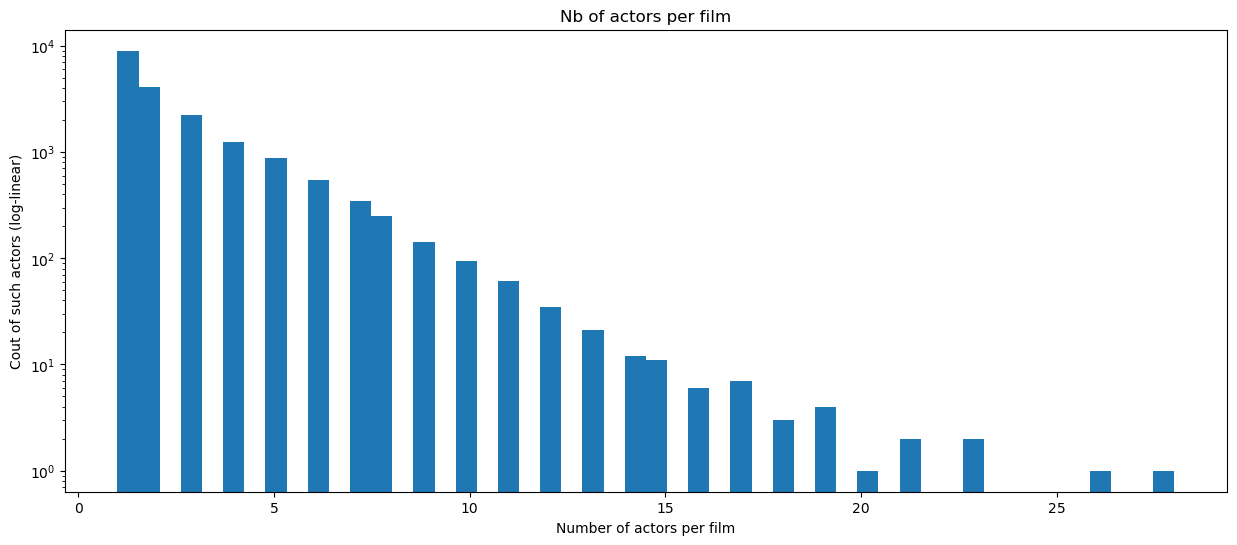

In [193]:
characters_per_film = characters.groupby('Wikipedia_movie_ID')
fig,ax = plt.subplots(figsize=(15,6))
plt.hist(characters_per_film.agg('count').Freebase_actor_ID,bins=50)
ax.set(yscale='log')
plt.title('Nb of actors per film')
plt.xlabel('Number of actors per film')
plt.ylabel('Cout of such actors (log-linear)')
None

A beautiful power-law, which tells us that only the major characters are registered in the database for the majority of films.

### Some evolutions

Conversion of gender to {0,1} (0 for male, 1 for female).

In [194]:
characters.Actor_gender = (characters.Actor_gender=='F').apply(int)
characters.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_meters,Actor_ethnicity_Freebase_ID,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,1,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,0,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001.0,Commander Helena Braddock,1949.0,1,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
56,2314463,/m/0734w5,2006.0,Taper Guy,1971.0,0,1.87,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
76,612710,/m/02wjqm,1999.0,Sandii,1975.0,1,1.68,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


Text(0.5, 1.0, 'Evolution of the fraction of women in the film (1=female)')

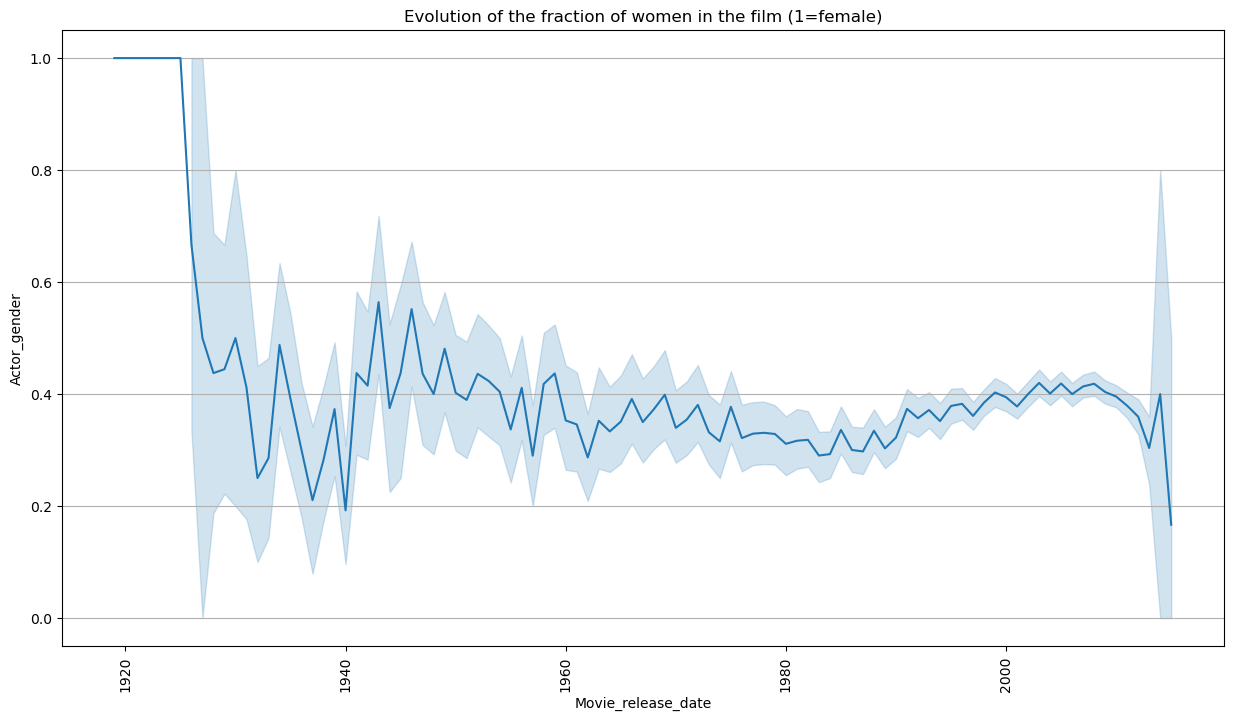

In [196]:
fig,ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_gender', ax=ax)
plt.grid(visible=True, axis='y')
plt.xticks(rotation=90)
plt.title('Evolution of the fraction of women in the film (1=female)')

About the age of actors

Text(0.5, 1.0, 'Evolution of median age of the actor (1=female)')

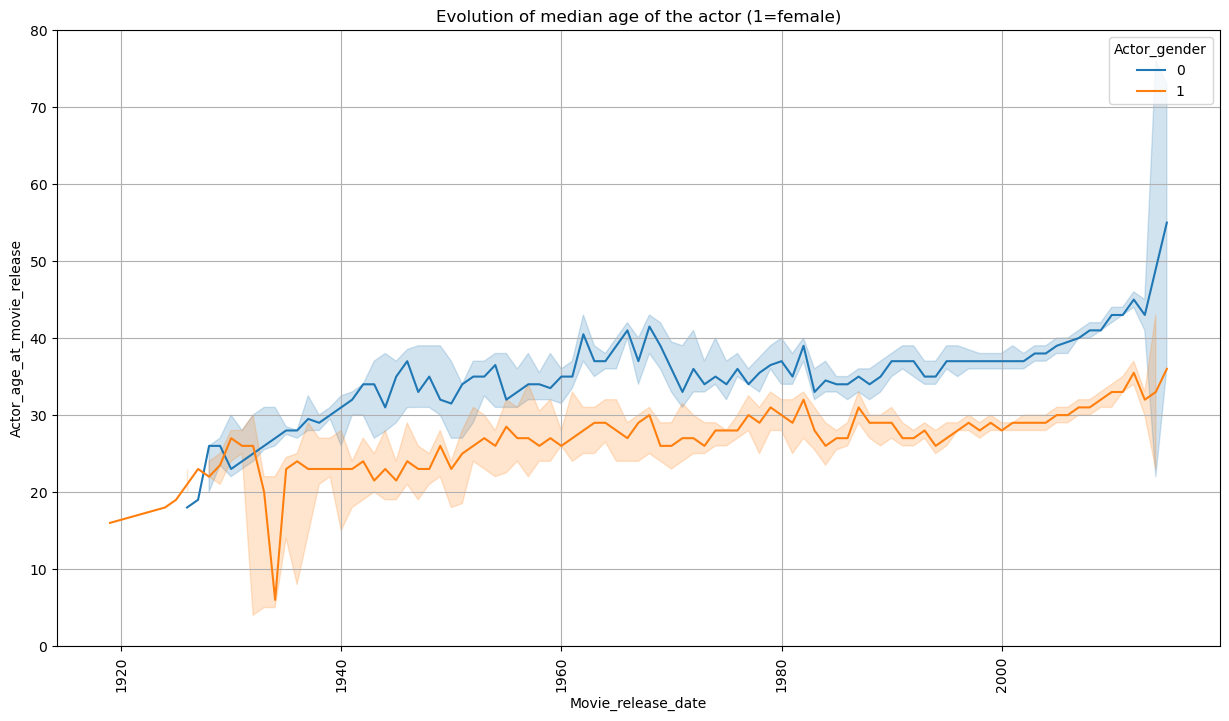

In [197]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_age_at_movie_release',hue='Actor_gender',estimator='median', ax=ax)
plt.grid(visible=True)
plt.xticks(rotation=90)
plt.ylim(0,80)
plt.title('Evolution of median age of the actor (1=female)')

# Question 1
How diverse are the actors genders in movies? How has this evolved over time? Does it change depending on genre? Movie language/place?

## New dataframe

To answer all these questions, we count the number of female/male per film

In [237]:
grouped = characters[['Wikipedia_movie_ID','Actor_gender']].groupby(characters.Wikipedia_movie_ID)
df_gender = grouped.agg('sum')
df_gender['nb_m'] = grouped['Actor_gender'].agg('count').values - grouped['Actor_gender'].agg('sum').values
df_gender.rename(columns = {'Actor_gender':'nb_f'}, inplace = True)
df_gender['ratio'] = df_gender['nb_f']/(df_gender['nb_f']+df_gender['nb_m'])*100
df_gender.head()

,nb_f,nb_m,ratio
Wikipedia_movie_ID,,,
3217,2,0,100.000000
3746,0,3,0.000000
3837,1,5,16.666667
4227,0,1,0.000000
4231,3,5,37.500000


In [267]:
global_mean = df_gender.ratio.mean()
global_mean

39.33073602555711

## Part of women in films over time

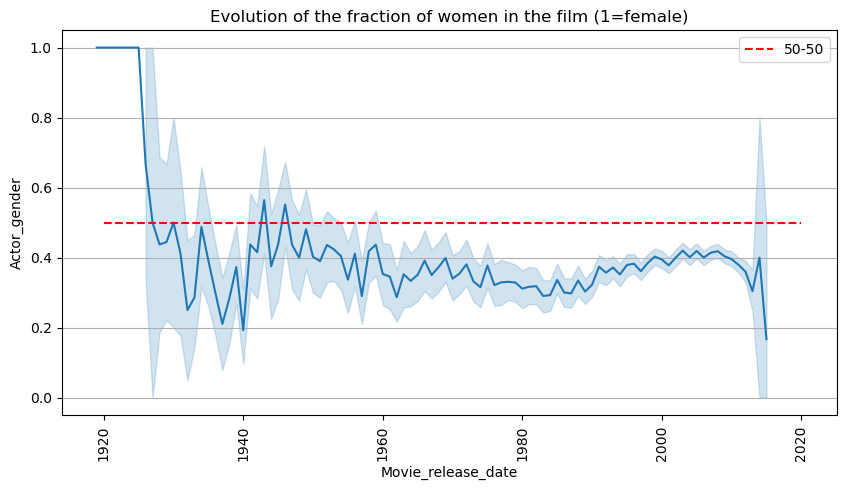

In [200]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data = characters, x=characters.Movie_release_date, y='Actor_gender', ax=ax)
plt.hlines(0.5,1920,2020,color='r',linestyle='--',label='50-50')
plt.grid(visible=True, axis='y')
plt.xticks(rotation=90)
plt.title('Evolution of the fraction of women in the film (1=female)')
plt.legend()

## Women in films per genre

In [201]:
gender_per_genre ={}
for idx,row in movies.iterrows():
    genre_list = row.Movie_genres
    try:
        nb_f,nb_m = df_gender.loc[row.Wikipedia_movie_ID,'nb_f'],df_gender.loc[row.Wikipedia_movie_ID,'nb_m']
    except KeyError:
        continue
    for g in genre_list:
        if g not in gender_per_genre:
            gender_per_genre[g] = [nb_m,nb_f]
        else:
            gender_per_genre[g][0] += nb_m
            gender_per_genre[g][1] += nb_f
df_gender_per_genre = pd.DataFrame.from_dict(gender_per_genre,orient='index')
df_gender_per_genre['ratio'] = df_gender_per_genre[1]/(df_gender_per_genre[0]+df_gender_per_genre[1])*100
df_gender_per_genre.sort_values(by='ratio',inplace=True,ascending=False)
df_gender_per_genre_lim = df_gender_per_genre[df_gender_per_genre[0]+df_gender_per_genre[1] >= 800]
df_gender_per_genre.head(4)

,0,1,ratio
Hardcore pornography,0,1,100.0
Breakdance,0,1,100.0
Filipino Movies,0,1,100.0
Women in prison films,0,2,100.0


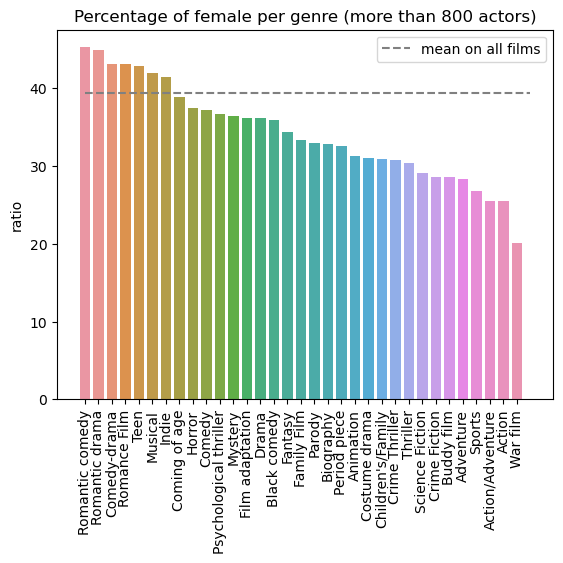

In [268]:
sns.barplot(data=df_gender_per_genre_lim, x=df_gender_per_genre_lim.index, y='ratio')
plt.hlines(global_mean,0,len(df_gender_per_genre_lim.index),linestyle='--',color='grey',label='mean on all films')
plt.xticks(rotation=90)
plt.title('Percentage of female per genre (more than 800 actors)')
plt.legend()

And for the 5 main genres:

In [203]:
N = 5
for elt in sorted_genres[:N]:
    print('{genre} ({nb} films): {ratio:.1f}\% of females'.format(genre=elt[0],nb=elt[1],ratio = df_gender_per_genre.loc[elt[0],'ratio']))

Drama (4265 films): 36.1\% of females
Comedy (3166 films): 37.2\% of females
Romance Film (2026 films): 43.1\% of females
Thriller (1945 films): 30.4\% of females
Action (1744 films): 25.5\% of females


## Women in films per language/location

Are their more inequalities in some countries or for some languages?

In [214]:
gender_per_country ={}
film_per_country = {}
gender_per_language = {}
film_per_language = {}
for idx,row in movies.iterrows():
    countries = row.Movie_countries
    languages = row.Movie_languages
    
    # Recover the number of females/males for the film
    try:
        nb_f,nb_m = df_gender.loc[row.Wikipedia_movie_ID,'nb_f'],df_gender.loc[row.Wikipedia_movie_ID,'nb_m']
    except KeyError:
        continue
    
    # Update the countries
    for country in countries:
        if country not in gender_per_country:
            gender_per_country[country] = [nb_m,nb_f]
            film_per_country[country] = 1
        else:
            gender_per_country[country][0] += nb_m
            gender_per_country[country][1] += nb_f
            film_per_country[country] += 1
            
    # Update the languages     
    for l in languages:
        if l not in gender_per_language:
            gender_per_language[l] = [nb_m,nb_f]
            film_per_language[l] = 1
        else:
            gender_per_language[l][0] += nb_m
            gender_per_language[l][1] += nb_f
            film_per_language[l] += 1

# Convert the dictionnaries to dataframes, and compute the percentage of female actress
gender_per_country = pd.DataFrame.from_dict(gender_per_country,orient='index')
gender_per_country['ratio'] = gender_per_country[1]/(gender_per_country[0]+gender_per_country[1])*100
gender_per_country.sort_values(by='ratio',inplace=True,ascending=False)
gender_per_country_lim = gender_per_country[gender_per_country[0]+gender_per_country[1] >= 50]

gender_per_language = pd.DataFrame.from_dict(gender_per_language,orient='index')
gender_per_language['ratio'] = gender_per_language[1]/(gender_per_language[0]+gender_per_language[1])*100
gender_per_language.sort_values(by='ratio',inplace=True,ascending=False)
gender_per_language_lim = gender_per_language[gender_per_language[0]+gender_per_language[1] >= 50]

# Sort the counts for countries and languages
film_per_country = {key: val for key, val in sorted(film_per_country.items(), key = lambda ele: ele[1], reverse=True)}
film_per_language = {key: val for key, val in sorted(film_per_language.items(), key = lambda ele: ele[1], reverse=True)}

gender_per_country_lim.head(5)

,0,1,ratio
Mexico,32,27,45.762712
South Korea,62,48,43.636364
Spain,135,89,39.732143
Italy,228,147,39.200000
India,52,33,38.823529


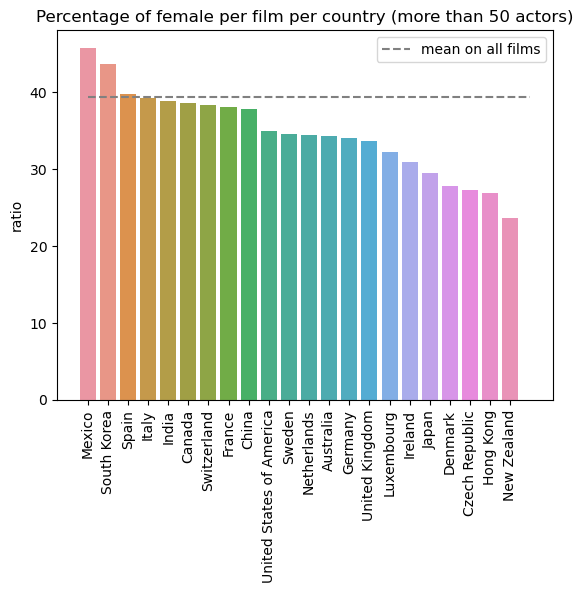

In [269]:
sns.barplot(data=gender_per_country_lim, x=gender_per_country_lim.index, y='ratio')
plt.hlines(global_mean,0,len(gender_per_country_lim.index),linestyle='--',color='grey',label='mean on all films')
plt.xticks(rotation=90)
plt.title('Percentage of female per film per country (more than 50 actors)')
plt.legend()

For the 5 most represented countries (5 countries where there are the most films).

MUST ADD SOME CONFIDENCE INTERVALS

In [216]:
N = 5
count = 0
for key,val in film_per_country.items():
    print('{country} ({nb} films): {ratio:.1f}\% of females'.format(country=key,nb=val, ratio = gender_per_country.loc[key,'ratio']))
    count += 1
    if count == N:
        break

United States of America (5239 films): 34.9\% of females
United Kingdom (790 films): 33.6\% of females
Germany (374 films): 34.0\% of females
France (362 films): 38.0\% of females
Canada (248 films): 38.5\% of females


In [217]:
gender_per_language_lim.head()

,0,1,ratio
American English,64,51,44.347826
American Sign Language,33,19,36.538462
Hindi Language,74,42,36.206897
English Language,13620,7284,34.845006
French Language,996,525,34.516765


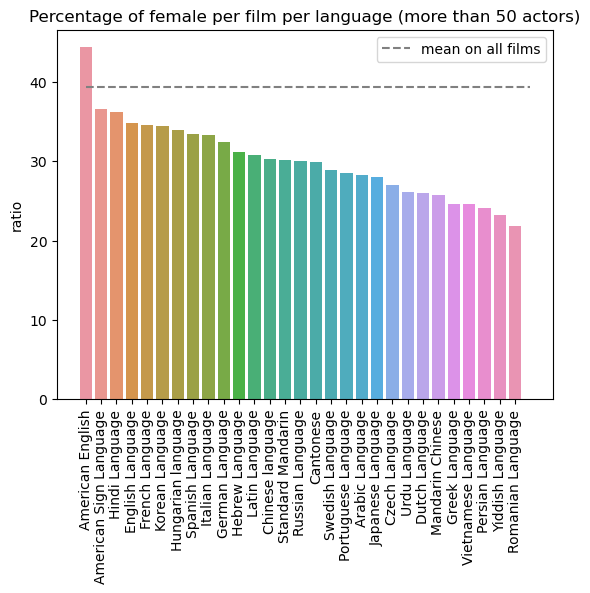

In [270]:
sns.barplot(data=gender_per_language_lim, x=gender_per_language_lim.index, y='ratio')
plt.hlines(global_mean,0,len(gender_per_language_lim.index),linestyle='--',color='grey',label='mean on all films')
plt.xticks(rotation=90)
plt.title('Percentage of female per film per language (more than 50 actors)')
plt.legend()

For the 5 most represented languages (5 languages where there are the most films).

In [224]:
N = 5
count = 0
for key,val in film_per_language.items():
    print('{language} ({nb} films): {ratio:.1f}\% of females'.format(language=key,nb=val, ratio = gender_per_language_lim.loc[key,'ratio']))
    count += 1
    if count == N:
        break

English Language (5583 films): 34.8\% of females
French Language (387 films): 34.5\% of females
Spanish Language (358 films): 33.4\% of females
German Language (211 films): 32.4\% of females
Italian Language (192 films): 33.4\% of females


## Women in films according to the success

### Success = revenue

We want to test the hypothesis that the percentage of women playing a role in a film has an impact on the revenue of the film (positive or negative, to see).

List of potential counfounders that can impact the revenue of a movie:
- Release year
- Genre of the film
- Countries where the film is seen -- Languages of the film

As we have many countries which are not represented equally, we will first study our hypothesis for films in the USA, with English language ($\approx 5000$ films).

We will create two groups (low and high still to be defined):
- control group: films with "low" percentage of women
- treated group: films with "high" percentage of women

We will films from each group to create pairs of films that have similar release year and similar genres (similar still to be defined).

Then, we will compare the revenue in the two groups.

Confounders/effects not taken into account:
- the evolution of this potential impact (maybe before 1968 there was a positive impact, and now a negative one for instance): we assume the effect does not evolve.
- is our dataset representing of the true distribution of films characteristics (genres, nb films per year,...) ? We assume that yes, it is.
- Movie budget: we must assume that it is independant of the number of women in the movie...

**Definitions**:
- Definition of distance between film 1 $f_1$ and film 2 $f_2$:
$$
    \text{distance}(f_1,f_2) = \frac{|\text{year}_1 - \text{year}_2|}{\sigma_\text{year}} + \frac{|\text{genres}_1 \cup \text{genres}_2|}{|\text{genres}_1 \cap \text{genres}_2|}-1
$$
- Definition of low (L) and high (H) percentage of women (percentage female):
$$
    f \in L \iff \text{percentage female} \leq (\text{global mean} - \epsilon) \text{ and } (\text{nb actors}  \geq N) \\
    f \in H \iff \text{percentage female} \geq (\text{global mean} + \epsilon) \text{ and } (\text{nb actors}  \geq N)
$$
where, $\epsilon = 10\%$ and $N=5$.

TO DO:
- take only USA & english language
- take a better distance -> adapt the year distance to evolution of revenue, and weight better genres and year

In [435]:
eps = 10
nb_actor = 5
sigma_y = movies.Movie_release_date.std()
print('Standrad deviation on release year: {s:.1f}'.format(s=sigma_y))
print(len(df_gender[(df_gender.ratio < global_mean-eps)&(df_gender.nb_f + df_gender.nb_m >= nb_actor)]))
print(len(df_gender[(df_gender.ratio > global_mean+eps)&(df_gender.nb_f + df_gender.nb_m >= nb_actor)]))

Standrad deviation on release year: 19.6
995
641


Without matching:

In [604]:
control_df = df_gender[df_gender.ratio < global_mean-eps]
treat_df = df_gender[df_gender.ratio > global_mean+eps]
movies['log_revenue'] = movies.Movie_box_office_revenue.apply(np.log)
movies_control = movies[movies.Wikipedia_movie_ID.isin(control_df.index)]
movies_treat = movies[movies.Wikipedia_movie_ID.isin(treat_df.index)]

# Standrad deviation in log revenue, and log(geometric means)
std_control = movies_control.log_revenue.std()
std_treat = movies_treat.log_revenue.std()
mean_control = movies_control.log_revenue.mean()
mean_treat = movies_treat.log_revenue.mean()

Text(0.5, 0.98, 'Box office revenue (log-scale)')

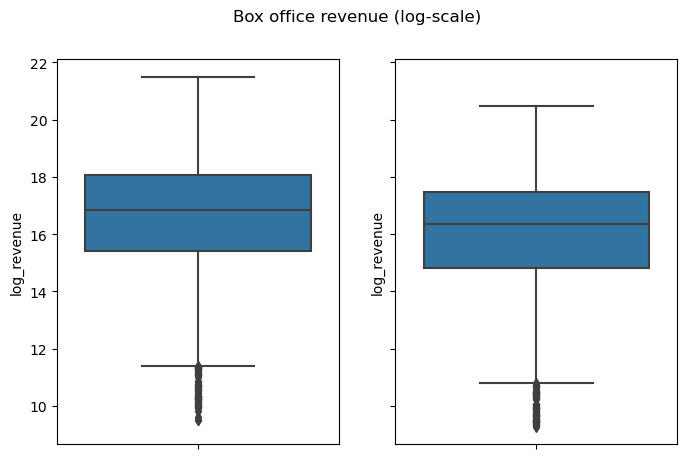

In [570]:
fig,axs = plt.subplots(1,2,figsize=(8,5),sharey=True)
sns.boxplot(data = movies_control, y='log_revenue', ax=axs[0])
sns.boxplot(data = movies_treat, y='log_revenue', ax=axs[1])
#plt.yscale('log')
plt.suptitle('Box office revenue (log-scale)')

Text(0.5, 0.98, 'Median box office revenue')

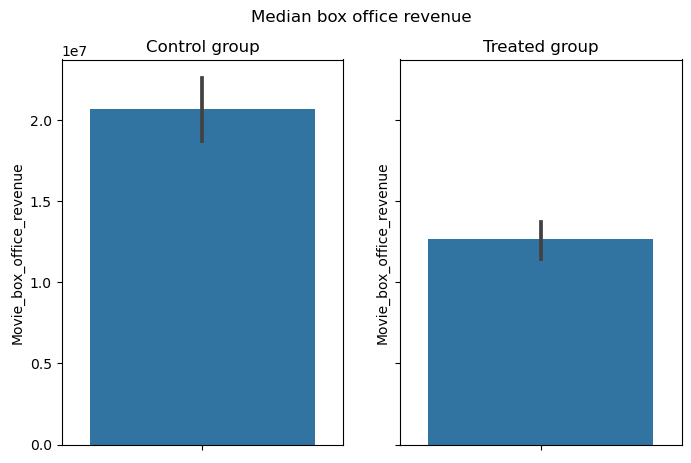

In [585]:
fig,axs = plt.subplots(1,2,figsize=(8,5),sharey=True)
sns.barplot(data = movies_control, y='Movie_box_office_revenue',estimator='median', ax=axs[0])
sns.barplot(data = movies_treat, y='Movie_box_office_revenue',estimator='median', ax=axs[1])
axs[0].set_title('Control group')
axs[1].set_title('Treated group')
#plt.yscale('log')
plt.suptitle('Median box office revenue')

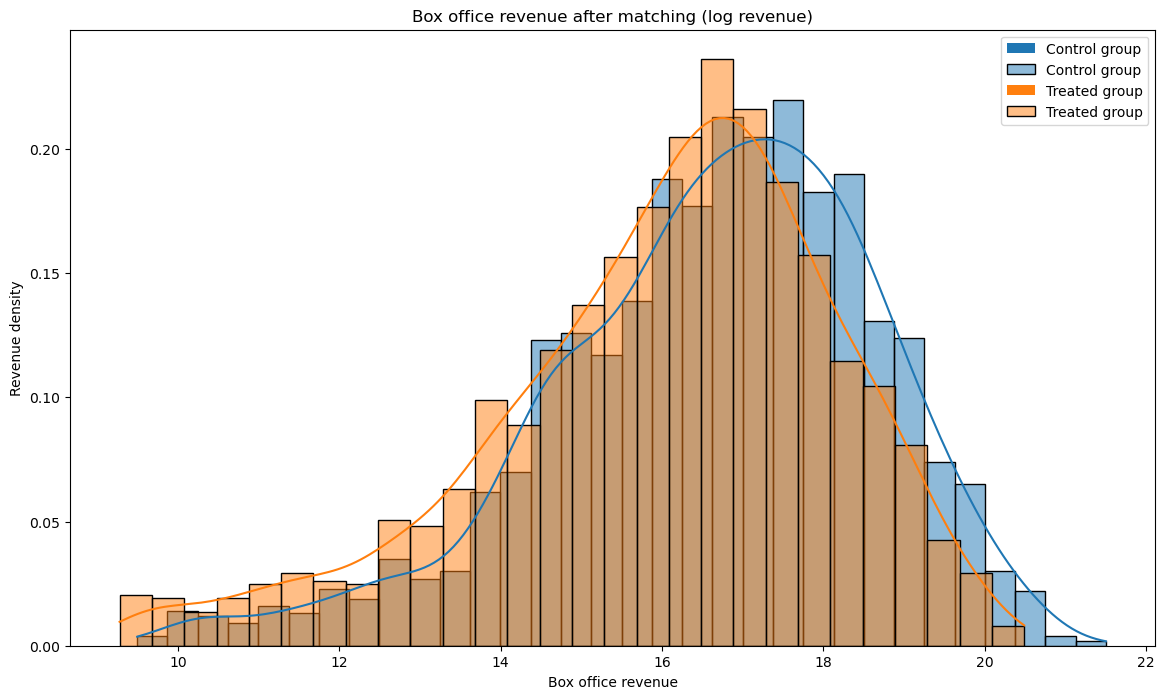

In [611]:
fig,ax = plt.subplots(figsize=(14,8))
sns.histplot(data = movies_control['log_revenue'],kde=True,stat='density', ax=ax,label='Control group')
sns.histplot(data = movies_treat['log_revenue'],kde=True,stat='density', ax=ax,label='Treated group')
ax.set(title='Box office revenue after matching (log revenue)',xlabel='Box office revenue', ylabel='Revenue density')
plt.legend()

We could tend to think that films in which there are less women are more successful (in term of box office revenue).

Matching process

In [462]:
def get_distance(diff_y, genres_1, genres_2, sigma_y=sigma_y):
    year = diff_y/sigma_y
    genres = len(genres_1 | genres_2)/len(genres_1 & genres_2)-1
    return year + genres

In [464]:
MATCH_DATA = False
if MATCH_DATA:
    from time import time
    # Separate the treatment and control groups
    control_df = df_gender[(df_gender.ratio < global_mean-eps)&(df_gender.nb_f + df_gender.nb_m >= nb_actor)]
    treatment_df = df_gender[(df_gender.ratio > global_mean+eps)&(df_gender.nb_f + df_gender.nb_m >= nb_actor)]

    # Create an empty undirected graph
    G = nx.Graph()

    deb = time()
    count = 0
    # Loop through all the pairs of instances
    for control_idx, control_row in control_df.iterrows():
        y1 = movies[movies.Wikipedia_movie_ID == control_idx]['Movie_release_date'].values
        if len(y1) != 1:
            continue
        y1 = y1[0]
        genres_1 = set(*movies[movies.Wikipedia_movie_ID == control_idx]['Movie_genres']) # most time consuming operation: access to df
        if len(genres_1) == 0:
            continue

        for treatment_idx, treatment_row in treatment_df.iterrows():
            # Calculate the similarity 
            y2 = movies[movies.Wikipedia_movie_ID == treatment_idx]['Movie_release_date'].values
            if len(y2) != 1:
                continue
            y2 = y2[0]
            # do not accept if the diffference of years is to high, to make the algo faster
            diff_y = abs(y2-y1)
            if diff_y > sigma_y: # super fast
                continue

            genres_2 = set(*movies[movies.Wikipedia_movie_ID == treatment_idx]['Movie_genres']) # most time consuming operation: access to df
            if len(genres_2) == 0 or genres_1 & genres_2 == set():
                continue
            
            distance = get_distance(diff_y = diff_y, genres_1=genres_1, genres_2=genres_2, sigma_y=sigma_y) #super_fast

            # Add an edge between the two instances weighted by the similarity between them
            G.add_weighted_edges_from([(control_idx, treatment_idx, distance)]) # super fast
        count += 1
        """
        if count == 10:
            break
        """
    print('Temps écoulé:',time()-deb)
    nx.write_gpickle(G, "Data/matching_1.gpickle")

else:
    G = nx.read_gpickle("Data/matching_1.gpickle")

Temps écoulé: 238.86129927635193


In [465]:
# Find the minimal matching by distance
matching = nx.algorithms.bipartite.matching.minimum_weight_full_matching(G) #(Wiki_id_control, Wiki_id_treat)

C:\Users\samje\anaconda3\lib\site-packages\networkx\algorithms\bipartite\matching.py:569: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  weights_sparse = biadjacency_matrix(


In [507]:
# Observe the matchings
count = 0
for key,val in matching.items():
    print('---',count,'---')
    print('Control')
    print(movies[movies.Wikipedia_movie_ID == key][['Movie_release_date','Movie_genres']].values)
    print('Treat')
    print(movies[movies.Wikipedia_movie_ID == val][['Movie_release_date','Movie_genres']].values)
    count += 1
    if count == 3:
        break

--- 0 ---
Control
[[2007.0
  list(['Parody', 'Science Fiction', 'Drama', 'Comedy', 'Fantasy', 'Time travel'])]]
Treat
[[2007.0
  list(['Romantic comedy', 'Sex comedy', 'Drama', 'Comedy', 'Fantasy', 'Romance Film'])]]
--- 1 ---
Control
[[1984.0
  list(['Crime Fiction', 'Gangster Film', 'Indie', 'Musical', 'Period piece', 'Drama', 'Romantic drama', 'Romance Film', 'Musical Drama'])]]
Treat
[[1983.0
  list(['Musical', 'Feminist Film', 'Drama', 'Romance Film', 'Musical Drama'])]]
--- 2 ---
Control
[[1997.0
  list(['Crime Fiction', 'Thriller', 'Indie', 'Mystery', 'Drama', 'Comedy', 'Crime Thriller', 'Black comedy'])]]
Treat
[[1993.0
  list(['Thriller', 'Indie', 'Screwball comedy', 'Comedy Thriller', 'Mystery', 'Comedy', 'Crime Thriller', 'Black comedy'])]]


In [605]:
# Creation of the new dataframe
df_match = movies[movies.Wikipedia_movie_ID.isin(list(matching.keys()) + list(matching.values()))]
for key,val in matching.items():
    df_match.loc[df_match.Wikipedia_movie_ID == key,'group'] = 'control'
    df_match.loc[df_match.Wikipedia_movie_ID == val,'group'] = 'treat'
df_match.head()

C:\Users\samje\AppData\Local\Temp\ipykernel_19540\3777819585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match.loc[df_match.Wikipedia_movie_ID == key,'group'] = 'control'


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,log_revenue,group
13,171005,/m/016ywb,Henry V,1989.0,10161099.0,137.0,[English Language],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",16.134077,treat
222,3033993,/m/08m1s2,Becoming Jane,2007.0,37311672.0,112.0,[English Language],"[Ireland, United Kingdom]","[Biography, Costume drama, Period piece, Drama...",17.434817,control
289,3681139,/m/09v460,Necessary Roughness,1991.0,26255594.0,108.0,[English Language],[United States of America],"[Sports, Comedy]",17.083390,treat
298,5549065,/m/0ds11z,Sweeney Todd: The Demon Barber of Fleet Street,2007.0,152523164.0,117.0,[English Language],"[United States of America, United Kingdom]","[Crime Fiction, Tragedy, Horror, Supernatural,...",18.842827,treat
346,1033297,/m/0401sg,Resident Evil,2002.0,102441078.0,100.0,[English Language],"[United States of America, France, Canada, Uni...","[Thriller, Science Fiction, Horror, Adventure,...",18.444798,control


Text(0.5, 1.0, 'Evolution of median box office revenue per year (log-linear)')

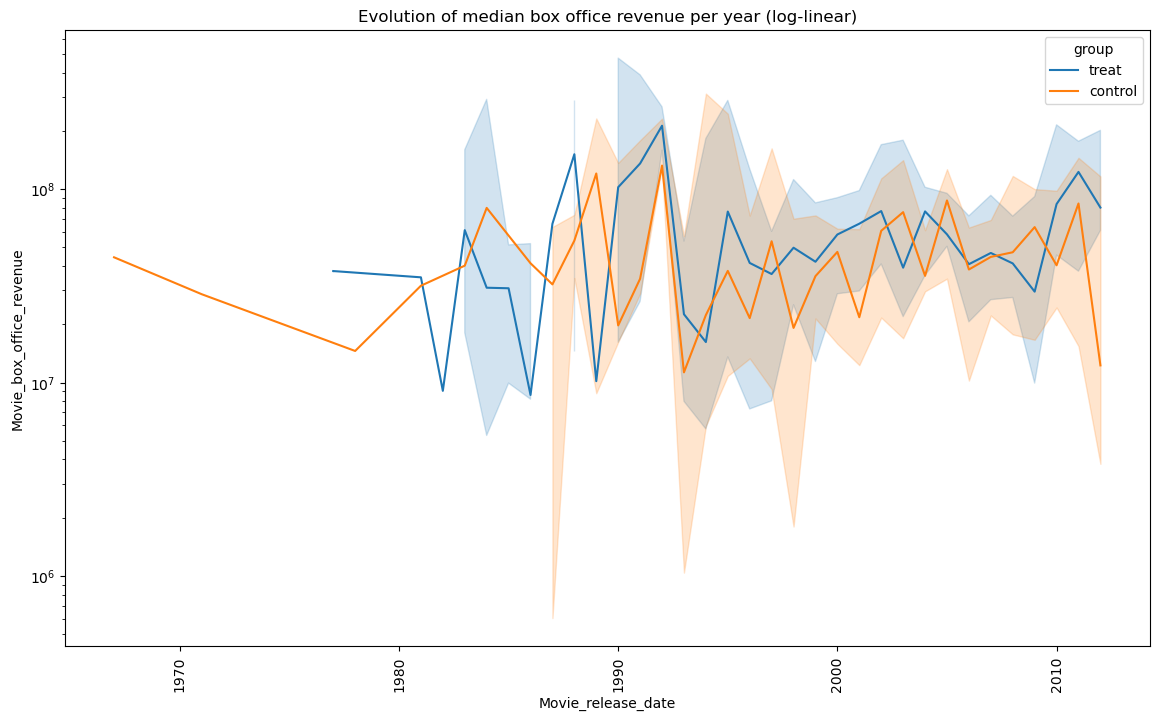

In [606]:
fig,ax = plt.subplots(figsize=(14,8))
sns.lineplot(data = df_match, x='Movie_release_date', y='Movie_box_office_revenue',estimator='median', ax=ax,hue='group')
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Evolution of median box office revenue per year (log-linear)')

Text(0.5, 1.0, 'Box office revenue (log-scale)')

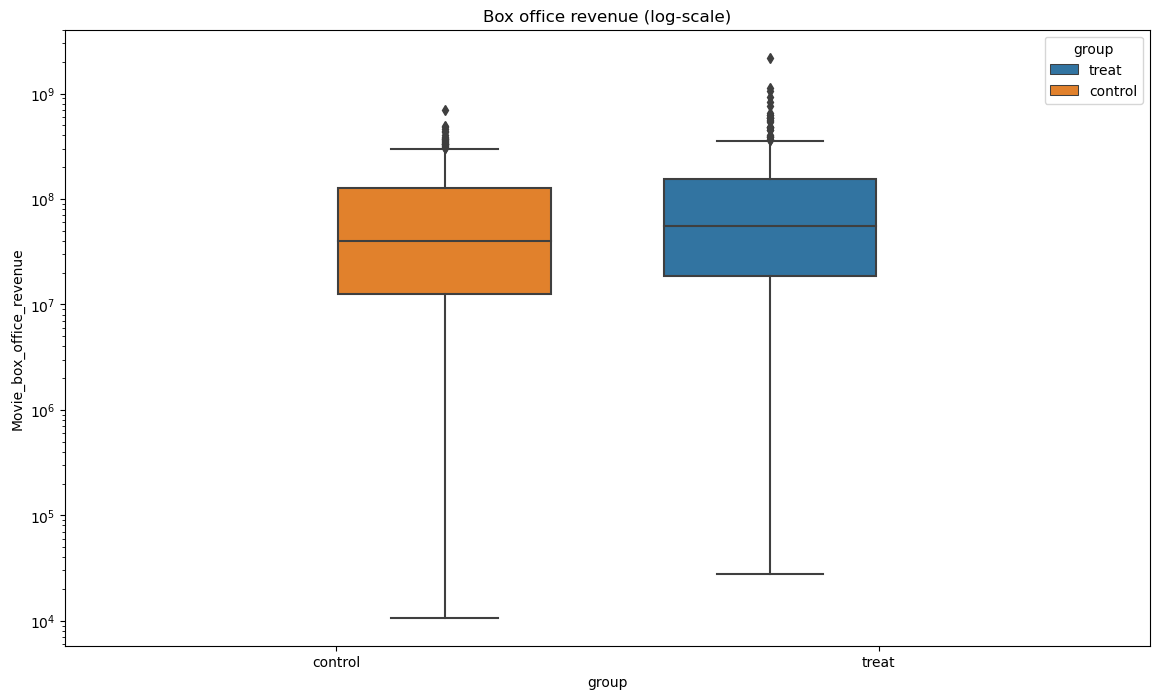

In [607]:
fig,ax = plt.subplots(figsize=(14,8))
sns.boxplot(data = df_match, y='Movie_box_office_revenue',x='group', hue='group',order=["control", "treat"], ax=ax)
#plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Box office revenue (log-scale)')

Text(0.5, 1.0, 'Median box office revenue')

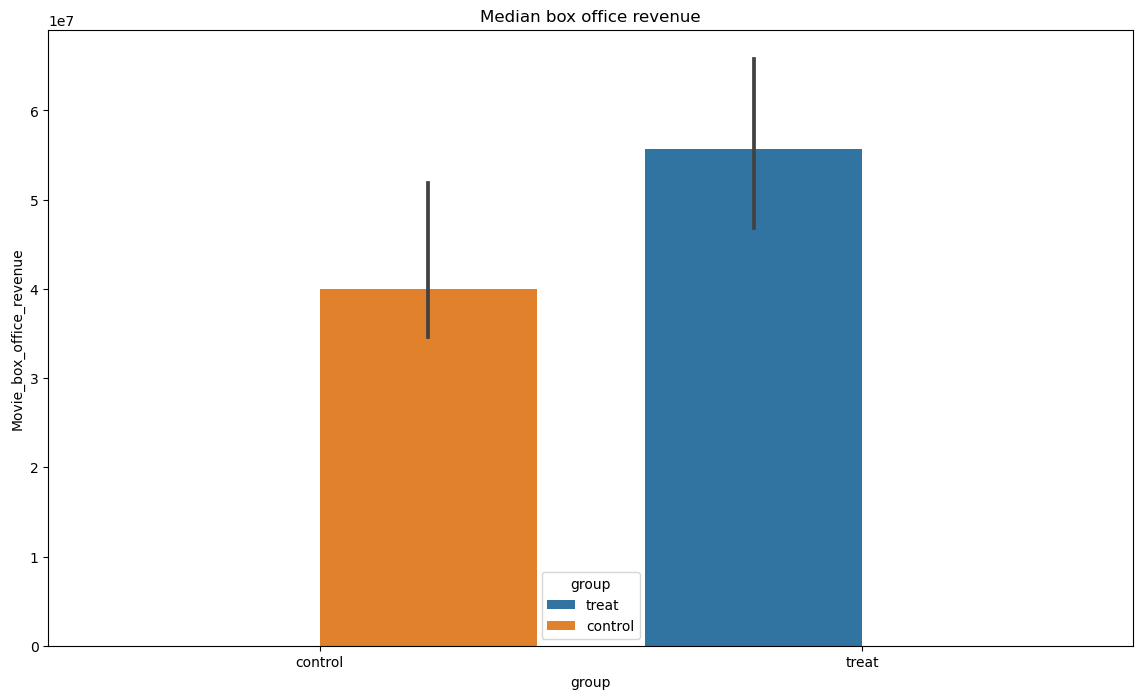

In [608]:
fig,ax = plt.subplots(figsize=(14,8))
sns.barplot(data = df_match, y='Movie_box_office_revenue',x='group',estimator='median', hue='group',order=["control", "treat"], ax=ax)
#plt.xticks(rotation=90)
#plt.yscale('log')
plt.title('Median box office revenue')

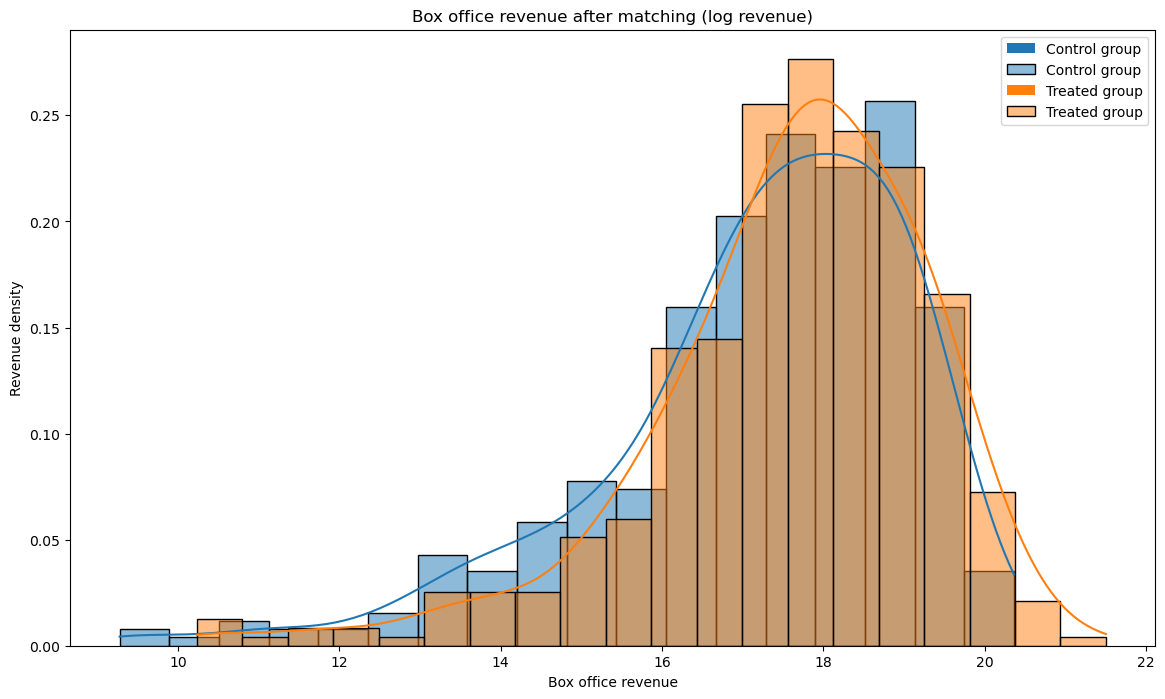

In [610]:
fig,ax = plt.subplots(figsize=(14,8))
sns.histplot(data = df_match[df_match.group == 'control']['log_revenue'],kde=True,stat='density', ax=ax,label='Control group')
sns.histplot(data = df_match[df_match.group == 'treat']['log_revenue'],kde=True,stat='density', ax=ax,label='Treated group')
ax.set(title='Box office revenue after matching (log revenue)',xlabel='Box office revenue', ylabel='Revenue density')
plt.legend()

Conclusion: we cannot conclude that one group performs better than the other, as the confidence intervals have a non-empty intersection, even though the graphs tend to show the opposite effect (films in which there are more women are more successful)